# Exploration of temporal NMS

Based on the papaer: https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2014/data/5209c239.pdf

In [46]:
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from data import tf_record_loading as loader
from prediction import prediction_utils as predictor
from data import bbox_utils as box

from statistics import compute_ap
from sklearn.metrics import auc

import cv2
import pickle

from procsessing.nms import greedy_nms, soft_nms, t_nms
from data import bbox_utils as box
import visualization
from visualization import draw_circles_from_boxes, plot_circles_from_boxes, write_video
import statistics

In [2]:
# Change default plot size
plt.rcParams['figure.figsize'] = [12, 6]

## Load Model and Data

In [3]:
DATA_PATH = "D:\\Nabil_object_detection\\val\\z00_tiles0_bboxes40.tfrecord"
MODEL_PATH = "D:\\Nabil_object_detection\\models\\graph_imgSize_vs_bboxSize\\ssd_resnet50_v1_fpn_10x_tiles0_bboxes40"

In [4]:
data = loader.load_tf_dataset(DATA_PATH)
model = predictor.load_model(MODEL_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


## Predictions

In [5]:
images = data.get("images")
gt_bboxes = data.get("bboxes")

In [6]:
# predictions = []

# for image in tqdm(images):
#     prediction = predictor.run_inference_for_single_image(model, image)
#     predictions.append(prediction)

predictions = pickle.load(open("predictions.p", "rb"))

## NMS on every image

### Prediction score vs. NMS

In [7]:
first_prediction = predictions[0].get("detection_boxes")[predictions[0].get("detection_scores") >= 0.0]
first_score = predictions[0].get("detection_scores")[predictions[0].get("detection_scores") >= 0.0]

In [16]:
greedy_scores = greedy_nms(first_prediction, first_score, 0.5)
soft_scores = soft_nms(first_prediction, first_score, 0.5)

In [17]:
greedy_predictions = first_prediction[greedy_scores >= 0.5]
soft_predictions = first_prediction[soft_scores >= 0.5]

In [18]:
prediction_points = box.boxes_to_center_points(first_prediction)
greedy_points = box.boxes_to_center_points(greedy_predictions)
soft_points = box.boxes_to_center_points(soft_predictions)

As can be seen in the image below, soft-NMS keeps more predictions. Especially in clustered areas, only the score gets decreased.

In [19]:
img_threshold = visualization.draw_circles_on_image(images[0], prediction_points[first_score >= 0.5], colors=first_score[first_score >= 0.5])
img_nms_vs_soft = visualization.draw_circles_on_image(images[0], soft_points, greedy_points)
img_nms_scores = visualization.draw_circles_on_image(images[0], greedy_points, colors=greedy_scores[greedy_scores >= 0.5])
img_soft_scores = visualization.draw_circles_on_image(images[0], soft_points, colors=soft_scores[soft_scores >= 0.5])

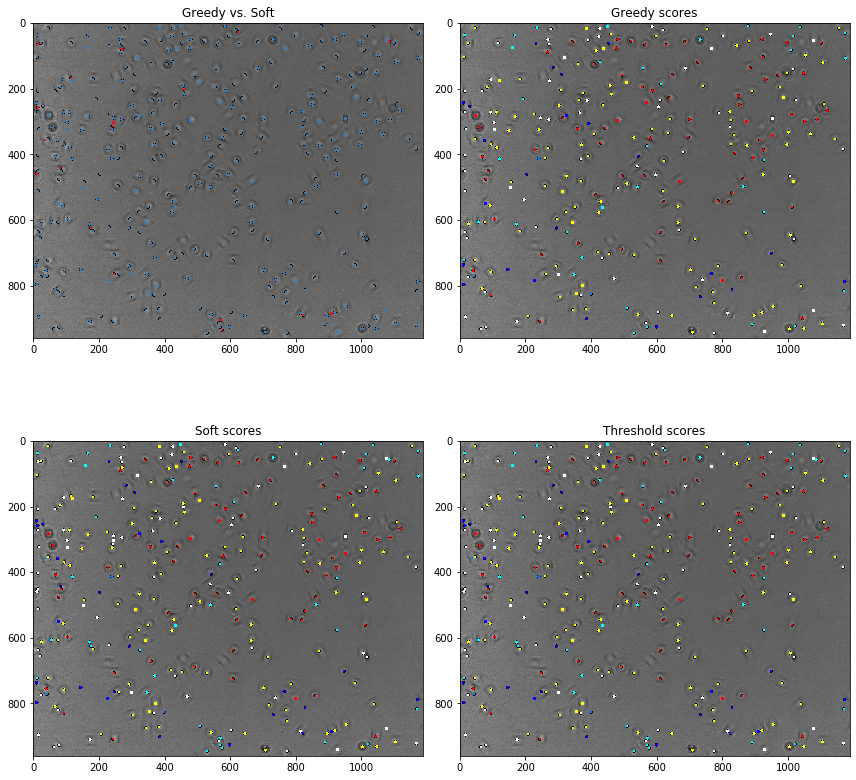

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

axs[0, 0].set_title("Greedy vs. Soft")
axs[0, 0].imshow(img_nms_vs_soft)

axs[0, 1].set_title("Greedy scores")
axs[0, 1].imshow(img_nms_scores)

axs[1, 0].set_title("Soft scores")
axs[1, 0].imshow(img_soft_scores)

axs[1, 1].set_title("Threshold scores")
axs[1, 1].imshow(img_threshold)

fig.tight_layout()
plt.show()

## Temporal NMS

In [39]:
# Get all predicitons

all_detections = [x.get("detection_boxes") for x in predictions]
all_scores = [x.get("detection_scores") for x in predictions]

t_detections, t_scores = t_nms(all_detections, all_scores, iou=0.5)

In [47]:
# Save predictions as videos

g = (draw_circles_from_boxes(image, detection[score >= 0.7]) for image, detection, score in zip(images, t_detections, t_scores))
write_video(g, "temporal.avi")

g = (draw_circles_from_boxes(image, detection[score >= 0.7]) for image, detection, score in zip(images, t_detections, t_scores))
write_video(g, "normal.avi")

True